### PreProcessing

In [2]:
import pandas as pd
df = pd.read_csv('/content/train.csv', encoding='utf-8', dtype='unicode')
df = df[['keyword','tweet','disaster']]
df.to_csv('/content/trainNew.csv',index=False)
df.head()

,keyword,tweet,disaster
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
import re

In [4]:
df.describe()

,keyword,tweet,disaster
count,7552,7613,7613
unique,221,7503,2
top,fatalities,11-Year-Old Boy Charged With Manslaughter of T...,0
freq,45,10,4342


In [5]:
df.dropna(subset=["keyword"], inplace=True)

In [6]:
df.head()

,keyword,tweet,disaster
31,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,ablaze,We always try to bring the heavy. #metal #RT h...,0
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,ablaze,Crying out for more! Set me ablaze,0
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [7]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

In [8]:
df['tweet'] = df['tweet'].apply(lambda x: cleaning_URLs(x))
df.head()

,keyword,tweet,disaster
31,ablaze,@bbcmtd Wholesale Markets ablaze,1
32,ablaze,We always try to bring the heavy. #metal #RT,0
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,ablaze,Crying out for more! Set me ablaze,0
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [9]:
def remove_username(data):
    temp = [re.sub('@[^\s]+','',data)]
    return temp[0]
df['tweet'] = df['tweet'].apply(lambda x: remove_username(x))

In [10]:
df.head()

,keyword,tweet,disaster
31,ablaze,Wholesale Markets ablaze,1
32,ablaze,We always try to bring the heavy. #metal #RT,0
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,ablaze,Crying out for more! Set me ablaze,0
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [11]:
def remove_hashes(data):
  temp = [re.sub('#','',data)]
  return temp[0]
df['tweet'] = df['tweet'].apply(lambda x: remove_hashes(x))
df['tweet'] = df['tweet'].str.lower()


In [12]:
df.head()

,keyword,tweet,disaster
31,ablaze,wholesale markets ablaze,1
32,ablaze,we always try to bring the heavy. metal rt,0
33,ablaze,africanbaze: breaking news:nigeria flag set ab...,1
34,ablaze,crying out for more! set me ablaze,0
35,ablaze,on plus side look at the sky last night it was...,0


In [13]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df['tweet']= df['tweet'].apply(lambda x: cleaning_punctuations(x))
df.head(10)

,keyword,tweet,disaster
31,ablaze,wholesale markets ablaze,1
32,ablaze,we always try to bring the heavy metal rt,0
33,ablaze,africanbaze breaking newsnigeria flag set abla...,1
34,ablaze,crying out for more set me ablaze,0
35,ablaze,on plus side look at the sky last night it was...,0
36,ablaze,mufc theyve built so much hype around new acq...,0
37,ablaze,inec office in abia set ablaze,1
38,ablaze,barbados bridgetown jamaica ûò two cars set a...,1
39,ablaze,ablaze for you lord d,0
40,ablaze,check these out sfw,0


In [14]:
df['tweet'].iloc[56]

'rt naayf first accident in years turning onto chandanee magu from near mma taxi rammed into me while i was halfway turned everyone conf\x89û'

In [15]:
def remove_weird(x):
  cleaned_text = [re.sub(r'[^\x00-\x7F]+', '', x)]
  return cleaned_text[0]
df['tweet']= df['tweet'].apply(lambda x: remove_weird(x))

In [16]:
df['tweet'].iloc[56]

'rt naayf first accident in years turning onto chandanee magu from near mma taxi rammed into me while i was halfway turned everyone conf'

In [17]:
df.head()

,keyword,tweet,disaster
31,ablaze,wholesale markets ablaze,1
32,ablaze,we always try to bring the heavy metal rt,0
33,ablaze,africanbaze breaking newsnigeria flag set abla...,1
34,ablaze,crying out for more set me ablaze,0
35,ablaze,on plus side look at the sky last night it was...,0


### Visualisation

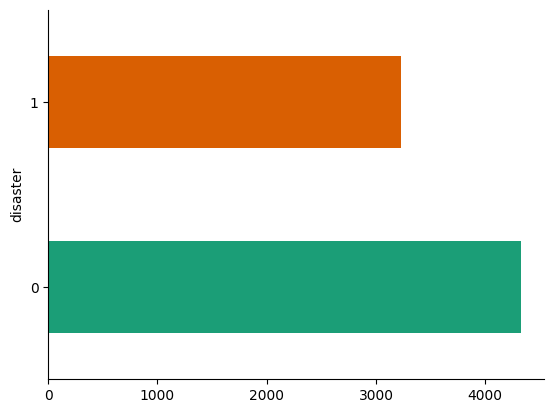

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('disaster').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Model Building

In [32]:
import tensorflow as tf
import keras
from keras.optimizers import *
from keras import regularizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split


In [34]:
X = df['tweet']
y = df['disaster'].astype(int)
lambda_ = 0.001
# Tokenize the text
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X)

# Convert text to sequences of integers
X_sequences = tokenizer.texts_to_sequences(X)


max_length = max(map(len, X_sequences))
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_sequences,
                                                         maxlen=max_length, padding='post')
X_padded, X_test, y, Y_test = train_test_split(X_padded, y, test_size = 0.2)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim
                              =len(tokenizer.word_index) + 1, output_dim=128,
                                                                  input_length=max_length),
    tf.keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, input_shape=(None, 1))),
    tf.keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, input_shape=(None, 1))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
Checkpoint = ModelCheckpoint("Weightsnew.keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=7, verbose=1, mode='auto')
lrr = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=0, factor=0.4, min_lr=1e-6, mode='min')

# Compile the model with a specified learning rate
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_padded, y, epochs=15, validation_split=0.2, callbacks=[Checkpoint])



Epoch 1/15
150/151 [============================>.] - ETA: 0s - loss: 0.6872 - accuracy: 0.5625
Epoch 1: val_accuracy improved from -inf to 0.56576, saving model to Weightsnew.keras
151/151 [==============================] - 15s 57ms/step - loss: 0.6871 - accuracy: 0.5631 - val_loss: 0.6836 - val_accuracy: 0.5658
Epoch 2/15
150/151 [============================>.] - ETA: 0s - loss: 0.6798 - accuracy: 0.5713
Epoch 2: val_accuracy did not improve from 0.56576
151/151 [==============================] - 4s 24ms/step - loss: 0.6798 - accuracy: 0.5720 - val_loss: 0.6765 - val_accuracy: 0.5658
Epoch 3/15
151/151 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.5882
Epoch 3: val_accuracy improved from 0.56576 to 0.62200, saving model to Weightsnew.keras
151/151 [==============================] - 3s 17ms/step - loss: 0.6598 - accuracy: 0.5882 - val_loss: 0.6355 - val_accuracy: 0.6220
Epoch 4/15
149/151 [============================>.] - ETA: 0s - loss: 0.6095 - accuracy: 

## found BEST accuracy AT 79.82% even thought the model is quite overfitting. This best accuracy weights will be taken for later predictions.

### Did predictions for the test set

In [35]:
# df2 =  pd.read_csv('/content/train.csv', encoding='utf-8', dtype='unicode')
# df2 = df2[['keyword','tweet']]
# df2.dropna(subset=["keyword"], inplace=True)
# df2['tweet'] = df2['tweet'].apply(lambda x: cleaning_URLs(x))
# df2['tweet'] = df2['tweet'].apply(lambda x: remove_username(x))
# df2['tweet'] = df2['tweet'].apply(lambda x: remove_hashes(x))
# df2['tweet'] = df2['tweet'].str.lower()
# df2['tweet']= df2['tweet'].apply(lambda x: cleaning_punctuations(x))
# df2['tweet']= df2['tweet'].apply(lambda x: remove_weird(x))
# df2.head()

In [36]:
import numpy as np
# testX = df2['tweet']
# tokenizer = tf.keras.preprocessing.text.Tokenizer()
# tokenizer.fit_on_texts(X)

# # Convert text to sequences of integers
# X_sequences_test = tokenizer.texts_to_sequences(X)


# max_length = max(map(len, X_sequences_test))
# X_padded_test = tf.keras.preprocessing.sequence.pad_sequences(X_sequences_test,
#                                                          maxlen=max_length, padding='post')
myMod = keras.models.load_model('/content/Weightsnew.keras')
y_pred = myMod.predict(X_test)
predicted_classes = np.where(y_pred > 0.5, 1, 0)


48/48 [==============================] - 2s 5ms/step


### GIVING ACCURACY AND F1 Score

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Calculate evaluation metrics
test_accuracy = accuracy_score(Y_test, predicted_classes)
print(classification_report(Y_test, predicted_classes))
print('Test accuracy:', test_accuracy)

              precision    recall  f1-score   support

           0       0.79      0.88      0.84       871
           1       0.81      0.69      0.75       640

    accuracy                           0.80      1511
   macro avg       0.80      0.79      0.79      1511
weighted avg       0.80      0.80      0.80      1511

Test accuracy: 0.800132362673726


### Tried with Naive Bayes approach to get a baseline score of how much better the bidirectional lstm model is comparatively

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle
X = df['tweet']
y = df['disaster'].astype(int)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
pickle.dump(tfidf_vectorizer, open("vectorizer.pickle", "wb"))
#pickle.load(open("vectorizer.pickle", 'rb'))     // Load vectorizer
model = pickle.load(open("vectorizer.pickle", 'rb'))
X_train = X
y_train = y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)
X_train = model.fit_transform(X_train)
X_test = model.fit_transform(X_test)

In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)

#predicted y
y_pred = naive_bayes_classifier.predict(X_test)

In [42]:
print(metrics.classification_report(y_test, y_pred, target_names=['Positive', 'Negative']))

              precision    recall  f1-score   support

    Positive       0.65      0.49      0.56       874
    Negative       0.48      0.64      0.55       637

    accuracy                           0.55      1511
   macro avg       0.56      0.56      0.55      1511
weighted avg       0.58      0.55      0.55      1511

